<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G/blob/main/Users/days/w1d6/feature_vizu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will reproduce some results of https://distill.pub/2017/feature-visualization/

Answer the questions and complete the code.

In [ ]:
%pip install einops -q

     |████████████████████████████████| 41 kB 415 kB/s 


In [ ]:
import torch
from torch import nn
import torchvision 
from torchvision import transforms

In [ ]:
model = torchvision.models.resnet34(pretrained=True)
model.eval();
# Why do we need to use model.eval()?
# To turn of batch normalization and dropout layers

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
import einops
import matplotlib.pyplot as plt


def imshow(img, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    if len(img.shape) == 4:
        img = img.squeeze(0)

    # Why do we need to rearange the dimensions?
    # Because we want each pixel to be in rgb
    img_reshaped = einops.rearrange(img, 'c w h -> w h c')
    plt.imshow(img_reshaped.detach())
    plt.xticks([])
    plt.yticks([])


In [ ]:
# Why do we need TFORM?
# Why do you have the right to use TFORM?
TFORM = transforms.Compose([
    transforms.Pad(12),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.RandomAffine(
        degrees=10, translate=(0.05, 0.05), scale=(1.2, 1.2), shear=10
    ),
])

In the same way as in the distill article, we will create several types of image parameterizations starting with the most naive parameterizations and going to the most efficient ones.
Images will be encoded as subclass of nn.Module, which will allow us to use pytorch abstractions to optimize images to maximize activation on a given class.

Please hide all forwards functions and try to write your own forwards functions.

### Naive parameterization

We can see the images simply as pixels independent of each other.

Note: By convention, in this TP, all images are in [0, 1]^3x224x224.

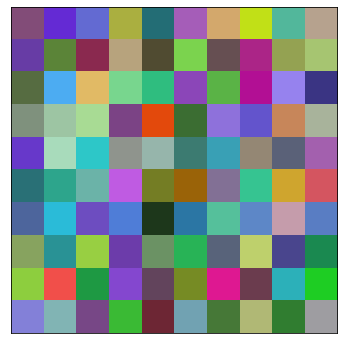

In [ ]:
IMAGE_INPUT_SIZE = (64,64)
class sigmoidImage(nn.Module):
    def __init__(self, original_image, shape=(10,10), position=(0,0),  rand = None):
        super().__init__()
        assert not max(position[i]+shape[i] > IMAGE_INPUT_SIZE[i]  for i in [0,1]), "patch doesn't fit in the image"
        self.image = nn.Parameter(torch.randn(1, 3, *shape) if rand is None else rand)
    def forward(self):
        return self.image.sigmoid()

img = sigmoidImage(None)
imshow(img())

After writing the image as an nn.module network, we can optimize the img to :
- maximize the activation of the resnet model for a given output class
- So that it displays the optimized image at the end of the optimization.

Hide and rewrite the body of the optimize_img function.

In [ ]:
from tqdm.autonotebook import tqdm


def optimize_img(img, model, lr=0.05, n_epochs=200, class_id=50, apply_transforms: bool =True):
    """Maximize the output of the resnet for a given class.
    
    Use Adam to optimize the image.
    """
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    img = img.to(DEVICE)
    model = model.to(DEVICE)
    model.eval()
    opt = torch.optim.Adam(img.parameters(), lr=lr)

    for _ in tqdm(range(n_epochs)):
        # Complete the following code 
      imgT = TFORM(img())  if (apply_transforms) else img()
      img.zero_grad()
      output = model(imgT)
        #  print(output)
      loss = -(output[0][class_id])
      loss.backward()
      opt.step()
    imshow(img().cpu())

 

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

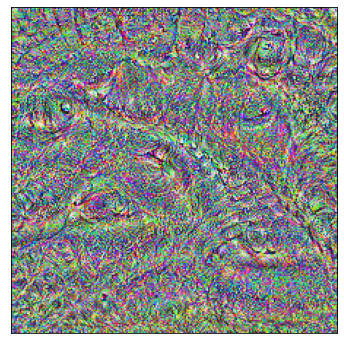

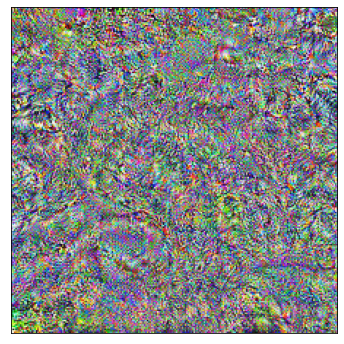

In [ ]:
r = torch.randn(1, 3, 224, 224)

optimize_img(sigmoidImage(r), model)

optimize_img(sigmoidImage(r), model, apply_transforms=False)


The results are not good. We will apply a transformation to change the color space, as well as to change the spatial space in order to obtain a better parameterization.

### Whitening_transformation

In [ ]:
# Here, we decorate the colors of the image.

# Read about cholewsky decomposition
# https://en.wikipedia.org/wiki/Whitening_transformation
# Why is it better to decorelate the colors of the image? 


projection = torch.Tensor( # calculé en fonction des distributions de couleur du dataset imagenet
    [[0.26, 0.09, 0.02],
    [0.27, 0.00, -0.05],
    [0.27, -0.09, 0.03]]
)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
projection = projection.to(DEVICE)

# explain what is happenning in the torch.einsum?
# Can you spot some errors in the decorrImage code?

# Un moyen + sophistiqué de faire ça serait de recalcuer itérativement la matrice de
#  projection en fonction des moyennes des activations
class decorrImage(nn.Module):

    def __init__(self, rand = None, sigmoid=True, scale=1.):
        super().__init__()
        self.image = nn.Parameter(torch.randn(1, 3, 224, 224) if rand is None else rand)  # décorélé
        self.scale : float = scale
        self.use_sigmoid : bool = sigmoid
    
    def forward(self):
        image = torch.einsum('bchw, Cc -> bChw', self.image, projection) # recorèle mais moyenne 0
        if self.use_sigmoid:
            return torch.sigmoid(image * self.scale + 0.5) # on devrait ajouter la moyenne des images qui activent le dataset
        else:
            return torch.clip(image * self.scale + 0.5, min=0.0, max=1.0)

# If you've spotted the errors, continue.

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

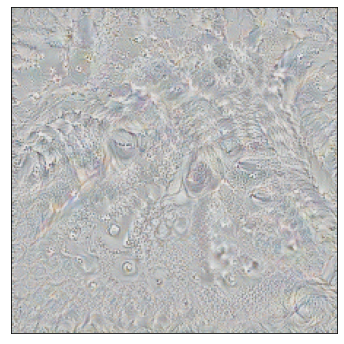

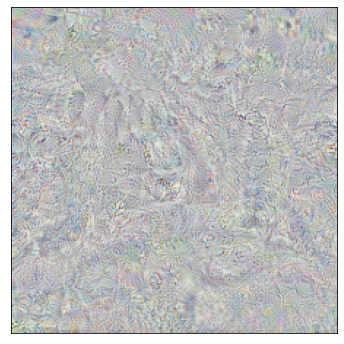

In [ ]:
r = torch.randn(1, 3, 224, 224)
img = decorrImage(rand=r, sigmoid=True)
optimize_img(img, model)
img = decorrImage(rand=r, sigmoid=True)
optimize_img(img, model, apply_transforms = False)

### Fourier

Skip this bonus part. First, go to the section inner seuron optimization.

In [ ]:
# Explain what is bad in the badFourierImage class?
class badFourierImage(nn.Module):
    def __init__(self, scale=1.0):
        super().__init__()
        self.freq = nn.Parameter(torch.randn(1, 3, 224, 113, 2))
        self.scale = scale
        
    def forward(self):
        image = torch.fft.irfft2(torch.view_as_complex(self.freq))
        return torch.clip(image * self.scale + 0.5, min=0.0, max=1.0)
    
class fourierImage(nn.Module):
    def __init__(self, scale=1.0, sigmoid=False, learnable_scale=False, rand=None):
        super().__init__()
        self.freq = nn.Parameter(torch.randn(1, 3, 224, 113, 2) if rand is None else rand)
        H, W = self.freq.shape[2:4]
        freq_magnitude = (torch.fft.fftfreq(H)[:,None]**2 + torch.fft.fftfreq(W)**2).sqrt()
        freq_magnitude[0, 0] = 1/H
        self.register_buffer('freq_magnitude', freq_magnitude)
        if learnable_scale:
            self.scale = nn.Parameter(torch.Tensor([scale]))
        else:
            self.scale = scale
        self.sigmoid = sigmoid
        
    def forward(self):        
        image = torch.fft.irfft2(torch.view_as_complex(self.freq) / self.freq_magnitude)
        image = image * self.scale + 0.5
        if self.sigmoid:
            return image.sigmoid()
        else:
            return torch.clip(image, min=0.0, max=1.0)
        
class decorrFourierImage(nn.Module):
    def __init__(self, scale=1.0, sigmoid=False):
        super().__init__()
        self.freq = nn.Parameter(torch.randn(1, 3, 224, 113, 2))
        H, W = self.freq.shape[2:4]
        freq_magnitude = (torch.fft.fftfreq(H)[:,None]**2 + torch.fft.fftfreq(W)**2).sqrt()
        freq_magnitude[0, 0] = 1/H
        self.register_buffer('freq_magnitude', freq_magnitude)
        self.scale = scale
        self.sigmoid = sigmoid
        projection = torch.Tensor(
            [[0.26, 0.09, 0.02],
             [0.27, 0.00, -0.05],
             [0.27, -0.09, 0.03]])
        self.register_buffer('projection', projection)
        
    def forward(self):        
        image = torch.fft.irfft2(torch.view_as_complex(self.freq) / self.freq_magnitude)
        image = torch.einsum('bchw, Cc -> bChw', image, self.projection)
        image = image * self.scale + 0.5
        if self.sigmoid:
            return image.sigmoid()
        else:
            return torch.clip(image, min=0.0, max=1.0)        

tensor([[[[0.6516, 0.3798, 0.6287,  ..., 0.5725, 0.6437, 0.4496],
          [0.5651, 0.2952, 0.2759,  ..., 0.5437, 0.6420, 0.6020],
          [0.6705, 0.3929, 0.4297,  ..., 0.6464, 0.7415, 0.6064],
          ...,
          [0.8801, 0.3642, 0.8585,  ..., 0.4649, 0.6360, 0.3630],
          [0.8969, 0.4323, 0.7089,  ..., 0.6914, 0.4201, 0.6646],
          [0.5973, 0.1571, 0.5953,  ..., 0.5209, 0.7221, 0.5588]]]],
       grad_fn=<ClampBackward1>)

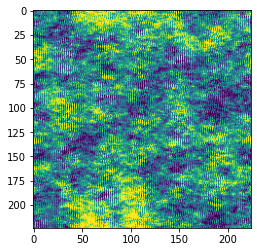

In [ ]:
r = torch.randn(1, 1, 224, 113,2)

img = fourierImage(scale=10, sigmoid=False, rand=r)
plt.imshow(torch.einsum('bchw -> hw', img()).detach())
img()

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

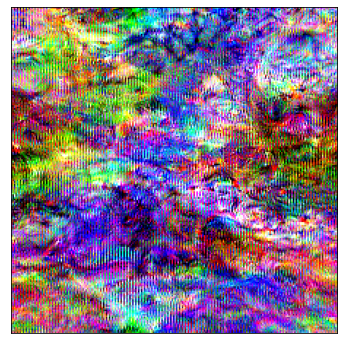

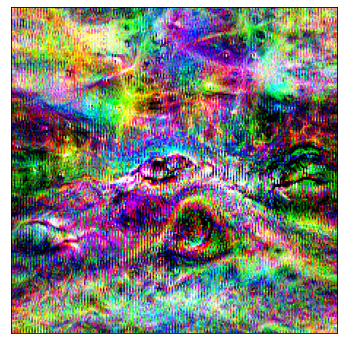

In [ ]:
optimize_img(img, model, apply_transforms=False)
# r = torch.randn(1, 3, 224, 224)
img = fourierImage(scale=10, rand=r)
optimize_img(img, model)

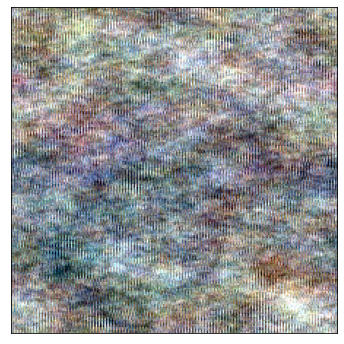

In [ ]:
img = decorrFourierImage(scale=20)
imshow(img())

100%|██████████| 300/300 [02:03<00:00,  2.43it/s]


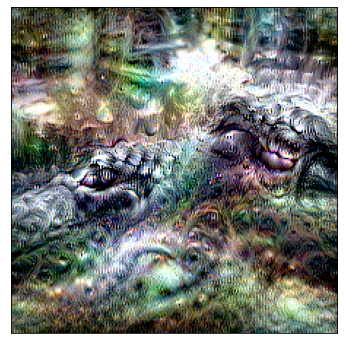

In [ ]:
optimize_img(img, model, apply_transforms=True, n_epochs=300)

# Inner neuron optimization

Instead of maximizing the activation of one of the output classes of the neural network, we can maximize the output of an inner neuron.

Here, we will maximize the activation of a given class at the output of a ReLU layer.

Read the following code, understand, hide and rewrite.

You will need to understand the notion of hook: https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks

To see some uses of hooks:
https://medium.com/the-dl/how-to-use-pytorch-hooks-5041d777f904#:~:text=PyTorch%20hooks%20are%20registered%20for,are%20used%20for%20debugging%20purposes.

In [ ]:
"""
In the first part of this NB, we tried to maximize directly the output probability of the network.
Now we will try to activate only one of the feature map.


Strategy:
We have a resnet with N layers.
In each layer, after the convolution, there is a Relu.

Layer N-1   ->     Layer N    ->     Layer N+1
  ...       -> Conv ->  ReLU  ->        ...
           forward hook here⤴


After the N-th ReLU, we obtain C feature map (aka C channels/color/features)
We will register a forward hook to maximize the output of one of those channels.

This feature map looks like a very pixelated image. 
We will try to maximize the activation of each one of its pixels by maximizing the sum of the pixels.
"""

class SaveOutput:
    def __init__(self):
        self.output = None

    # what does the dunder __call__ in python?
    # What is the meaning of those 4 arguments :self, module, module_in, module_out?
    def __call__(self, module, module_in, module_out):
        """Forward pytorch hook"""
        self.output = module_out
        
    def clear(self):
        self.output = None



def optimize_img_inner(img, model, relu_id, channel_id, lr=0.05, n_epochs=200, apply_transforms=False):
    # optimizes an image to activate some intermediate-layer channel of post-ReLU activation
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    img = img.to(DEVICE)
    model = model.to(DEVICE)
    opt = torch.optim.Adam(img.parameters(), lr=lr)
    
    post_relu = []
    # What is the purpose of this for loop?
    for i, m in enumerate(model.modules()):
        if isinstance(m, nn.ReLU):
            hook = SaveOutput()
            post_relu.append(hook)
            m.register_forward_hook(hook)
    
    # What is the purpose of this for loop?
    for i in tqdm(range(n_epochs)):
        opt.zero_grad()
        image = img()
        if apply_transforms:
            image = TFORM(image)
            
        for hook in post_relu:
            hook.clear()
        model(image)
        
        loss = -(post_relu[relu_id].output[0, channel_id] **2).sum()
        # Why do we need the minus?
        # Do we really need the **2?
        loss.backward()
        opt.step()

    imshow(img().cpu())

"""
Answer the different questions.
Bonus: Delete SaveOutput and use a global variable and a function instead of a class.
You can draw inspiration from the gradCam exercice: https://github.com/EffiSciencesResearch/ML4G/blob/main/days/w1d4/gradCam/Grad_CAM.ipynb
"""

'\nAnswer the different questions.\nBonus: Delete SaveOutput and use a global variable and a function instead of a class.\nYou can draw inspiration from the gradCam exercice: https://github.com/EffiSciencesResearch/ML4G/blob/main/days/w1d4/gradCam/Grad_CAM.ipynb\n'

In [ ]:
img = decorrFourierImage(scale=25.0)
optimize_img_inner(img, model, relu_id=6, channel_id=4, n_epochs=400)

"""
What happens when you change the relu_id? 
What happens when you change the channel_id?
take 15 minutes to browse openAi microscope: https://openai.com/blog/microscope/
"""